# Information of variables

# Input:
"$RD$": Relative density 
"$\alpha_{x}$": Rotation angles about the x-axis
"$\alpha_{y}$": Rotation angles about the y-axis
"$\alpha_{z}$": Rotation angles about the z-axis
"$E$": Elastic modulus
"$\nu$": Poisson's ratio
"$\rho$": Mass density
# Output:
"$w_{c}^{S}$": Central deflection of simply supported plate
"$w_{c}^{C}$": Central deflection of fully clamped plate
"$\dfrac{\omega_{1}^{S}}{2\pi}$": First natural frequency of simply supported plate
"$\dfrac{\omega_{2}^{S}}{2\pi}$": Second natural frequency of simply supported plate
"$\dfrac{\omega_{1}^{C}}{2\pi}$": First natural frequency of fully clamped plate
"$\dfrac{\omega_{2}^{C}}{2\pi}$": Second natural frequency of fully clamped plate

# Importing the required libraries

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from compare_methods import load_imputer

# Functions

In [47]:
def binary_sampler(p: float, rows: int, cols: int) -> np.ndarray:
    unif_random_matrix = np.random.uniform(0.0, 1.0, size=[rows, cols])
    binary_random_matrix = 1 * (unif_random_matrix < p)
    return binary_random_matrix

def single_nan_per_row(rows: int, cols: int) -> np.ndarray:
    mask = np.zeros((rows, cols), dtype=bool)
    for i in range(rows):
        # Randomly choose one column index to set as True (or 1)
        col_index = np.random.randint(cols)
        mask[i, col_index] = True
    return mask

def rmse_loss(ori_data: np.ndarray, imputed_data: np.ndarray, data_m: np.ndarray) -> np.ndarray:
    numerator = np.sum(((1 - data_m) * ori_data - (1 - data_m) * imputed_data) ** 2)
    denominator = np.sum(1 - data_m)
    return np.sqrt(numerator / float(denominator))

# Load the dataset

In [2]:
data_missing_full_name = pd.read_excel("dataset/incomplete_data_properties_materials.xlsx")
data_missing = data_missing_full_name[['Input_9.1', 'Input_9.2', 'Input_9.3']]

data = pd.read_excel("dataset/complete_data_properties_materials.xlsx")
data = data[['Input_9_1','Input_9_2','Input_9_3']]
df = data.sample(frac=1).reset_index(drop=True)

# Boxplot 

In [14]:
# Creating the dataframe again with the appropriate column names
df.columns = ["$E$", "$\\nu$", "$\\rho$"]
# Define colors for each variable
colors = ['skyblue', 'lightgreen', 'lightcoral']
# Plotting boxplots for each variable with the specified labels and colors
ax = plt.figure(figsize=(15, 5))

for i, (column, color) in enumerate(zip(df.columns, colors), 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[column], color=color)
    plt.title(column, fontsize=18)  # Increase title font size
    plt.ylabel(column, fontsize=0)
    plt.yticks(fontsize=16)  # Increase y-ticks font size
    plt.xticks(fontsize=16)  # Increase x-ticks font size

plt.tight_layout()
plt.show()
ax.savefig('results/boxplot.png')

# Comparaion of imputation methods

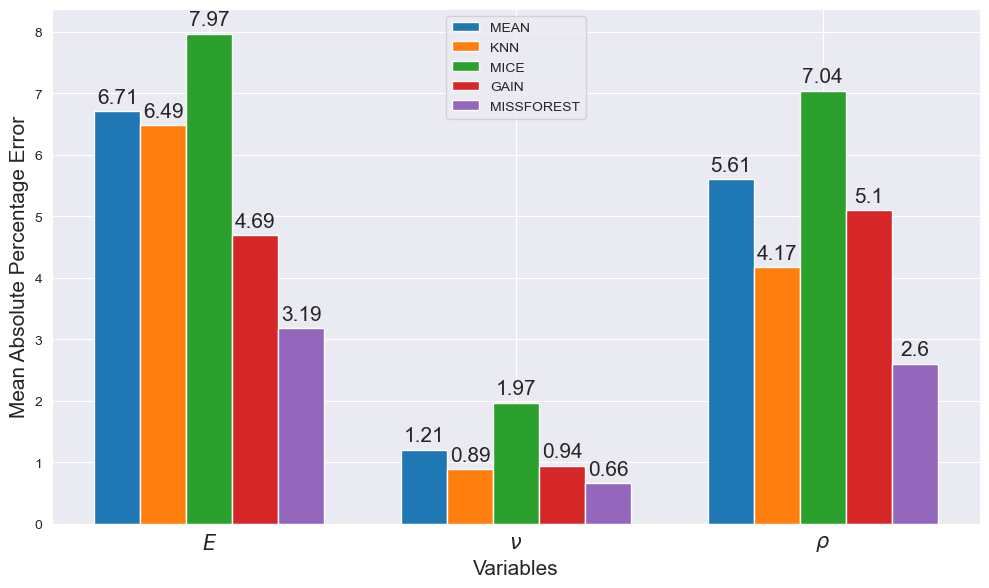

In [14]:
data = {
    "Var": ["$E$", "$\\nu$", "$\\rho$"],
    "MEAN": [6.712764, 1.205364, 5.609239],
    "KNN": [6.486604, 0.890275, 4.168798],
    "MICE": [7.970836, 1.968822, 7.041740],
    "GAIN": [4.694797, 0.944137, 5.099944],
    "MISSFOREST": [3.185006, 0.662822, 2.601712],
}

# Variables
variables = data["Var"]
methods = list(data.keys())[1:]  # Exclude 'Var'

# Values for each method
values = [data[method] for method in methods]

# Plotting
x = np.arange(len(variables))  # Label locations
width = 0.15  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create bar for each method
bars = []
for i, method_values in enumerate(values):
    bar = ax.bar(x + i * width, method_values, width, label=methods[i])
    bars.append(bar)

# Add values on top of each bar
for bar in bars:
    for rect in bar:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=15)

# Add labels, title, and legend
ax.set_xlabel('Variables',fontsize=15)
ax.set_ylabel('Mean Absolute Percentage Error',fontsize=15)
ax.set_xticks(x + width * (len(methods) - 1) / 2)
ax.set_xticklabels(variables,fontsize=15)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()
fig.savefig('results/compare_missing.png')

# Applying the Missforest imputer

In [14]:
X_MISSING = df.copy()  # This will have missing values
X_TRUTH = df.copy()  # This will have no missing values for testing

# Generate MCAR
X_MASK = binary_sampler(1 - 0.2, X_MISSING.shape[0], X_MISSING.shape[1])
X_MISSING[X_MASK == 0] = np.nan

datasize = X_MISSING.shape[0]
missingness = 0.2
feature_dims = X_MISSING.shape[1]

# Append indicator variables - One indicator per feature with missing values.
missing_idxs = np.where(np.any(np.isnan(X_MISSING), axis=0))[0]

seed_imputer_missforest = load_imputer("missforest")
X_seed_imputer_missforest = seed_imputer_missforest.fit_transform(data_missing)

In [14]:
df_result = pd.DataFrame(columns=['Name', 'Input_1','Input_2','Input_3','Input_4','Input_5', 'Input_6', 'Input_7', 'Input_8','Input_9_1','Input_9_2','Input_9_3'])

df_result['Name'] = data_missing_full_name['Name']
df_result['Input_9_1'] = X_seed_imputer_missforest[:,0]
df_result['Input_9_2'] = X_seed_imputer_missforest[:,1]
df_result['Input_9_3'] = X_seed_imputer_missforest[:,2]

df_result['Input_1'] = 1
df_result['Input_2'] = 1.5
df_result['Input_3'] = 0.1
df_result['Input_4'] = 1
df_result['Input_5'] = list(np.random.uniform(0.1,1,len(data_missing_full_name)))
df_result['Input_6'] = list(np.random.uniform(0,90,len(data_missing_full_name)))
df_result['Input_7'] = list(np.random.uniform(0,90,len(data_missing_full_name)))
df_result['Input_8'] = list(np.random.uniform(0,90,len(data_missing_full_name)))

In [65]:
df_result.to_excel("results/df_imputer_incomplete.xlsx", index=False)